<a href="https://colab.research.google.com/github/Ordo-Umbra/Void-Defect-Model/blob/main/copy_of_untitled19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

def gaussian_kernel(d, R):
    return np.exp(-2 * (R**2) * (d**2))

def compute_field(x, positions, energies, ranges):
    field = 0.0
    for i in range(len(positions)):
        d = np.linalg.norm(x - positions[i])
        field += energies[i] * gaussian_kernel(d, ranges[i])
    return field

def compute_force(i, positions, energies, ranges):
    ri = positions[i]
    force = np.zeros(3)
    for j in range(len(positions)):
        if i == j:
            continue
        rj = positions[j]
        d_vec = ri - rj
        d = np.linalg.norm(d_vec)
        if d == 0:
            continue
        grad = -4 * energies[j] * ranges[j]**2 * d_vec * np.exp(-2 * (ranges[j]**2) * (d**2))
        force += grad
    return force

In [ ]:
def initialize_particles(n):
    positions = np.random.uniform(-1, 1, (n, 3))
    velocities = np.zeros((n, 3))
    energies = np.ones(n) * 1.0
    ranges = np.ones(n) * 0.5
    return positions, velocities, energies, ranges

def tick(positions, velocities, energies, ranges, dt=0.01, chaos_amp=0.2):
    new_positions = positions.copy()
    new_velocities = velocities.copy()
    for i in range(len(positions)):
        force = compute_force(i, positions, energies, ranges)
        chaos = np.random.uniform(-1, 1, 3) * chaos_amp
        new_velocities[i] += dt * force + chaos
        new_positions[i] += dt * new_velocities[i]
    return new_positions, new_velocities

def run_simulation(n_particles=10, n_ticks=200, dt=0.01):
    positions, velocities, energies, ranges = initialize_particles(n_particles)
    trajectory = [positions.copy()]
    for _ in range(n_ticks):
        positions, velocities = tick(positions, velocities, energies, ranges, dt)
        trajectory.append(positions.copy())
    return trajectory, energies, ranges

In [ ]:
def sample_field(positions, energies, ranges, grid_size=50, bounds=((-1,1),(-1,1),(-1,1))):
    x_min, x_max = bounds[0]
    y_min, y_max = bounds[1]
    z_min, z_max = bounds[2]

    x = np.linspace(x_min, x_max, grid_size)
    y = np.linspace(y_min, y_max, grid_size)
    z = np.linspace(z_min, z_max, grid_size)

    field_grid = np.zeros((grid_size, grid_size, grid_size))

    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            for k, zk in enumerate(z):
                point = np.array([xi, yj, zk])
                field_grid[i, j, k] = compute_field(point, positions, energies, ranges)

    return field_grid, x, y, z

In [ ]:
trajectory, energies, ranges = run_simulation(n_particles=200, n_ticks=500, dt=0.01)
final_positions = trajectory[-1]

field, x, y, z = sample_field(final_positions, energies, ranges, grid_size=50)

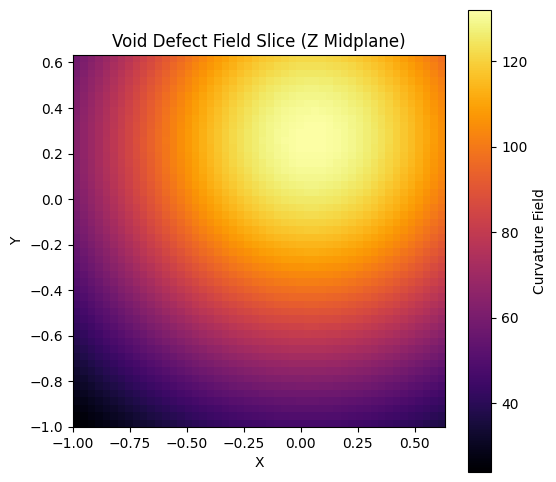

In [ ]:
import matplotlib.pyplot as plt

# Slice through the middle of the z-axis
mid_z = field.shape[2] // 2
field_slice = field[:, :, mid_z]

plt.figure(figsize=(6,6))
plt.imshow(field_slice, extent=[x[0], x[-10], y[0], y[-10]], origin='lower', cmap='inferno')
plt.colorbar(label='Curvature Field')
plt.title('Void Defect Field Slice (Z Midplane)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

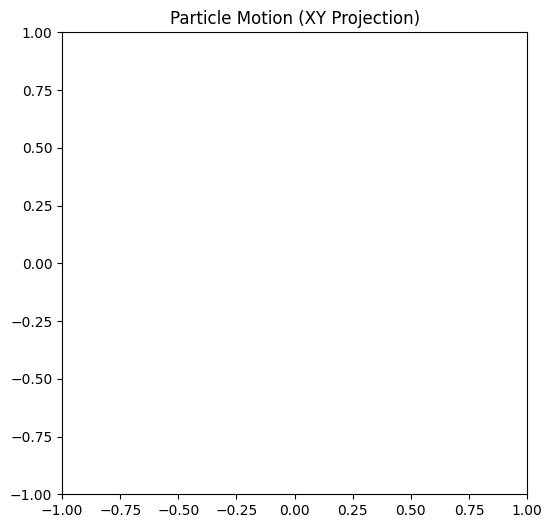

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

trajectory_array = np.array(trajectory)

fig, ax = plt.subplots(figsize=(6,6))
scat = ax.scatter([], [], s=50)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_title("Particle Motion (XY Projection)")

def update(frame):
    pos = trajectory_array[frame]
    scat.set_offsets(pos[:, :2])
    return scat,

ani = FuncAnimation(fig, update, frames=len(trajectory_array), interval=100)
plt.show()

In [ ]:
plt.imsave("field_slice.png", field_slice, cmap='inferno', origin='lower')

In [ ]:
for i in range(5):
    print(f"Tick {i}: {trajectory[i]}")

Tick 0: [[ 0.83372394  0.77481574  0.71743056]
 [-0.60260843  0.23423319 -0.65064186]
 [ 0.35951067  0.2458148  -0.54304947]
 [-0.14807847  0.84863592 -0.15945042]
 [ 0.56614287 -0.12242557  0.39568168]
 [ 0.16293589  0.80411688  0.30188999]
 [-0.98593648 -0.14054912 -0.8850771 ]
 [-0.47824478  0.11373861  0.0206894 ]
 [ 0.15738265  0.12394408  0.86801518]
 [-0.95040495 -0.58942526  0.4209898 ]]
Tick 1: [[ 0.83254192  0.77370983  0.71653624]
 [-0.60287419  0.23580694 -0.64973591]
 [ 0.35865642  0.24546133 -0.54339596]
 [-0.14806876  0.84656098 -0.1586582 ]
 [ 0.56586151 -0.12060149  0.39605628]
 [ 0.16172254  0.80347047  0.3007326 ]
 [-0.98440537 -0.14124313 -0.88414659]
 [-0.47913538  0.11240443  0.02264769]
 [ 0.15827271  0.12292254  0.86911817]
 [-0.95201975 -0.58848893  0.42198019]]
Tick 2: [[ 0.82999184  0.77383634  0.71647614]
 [-0.60330509  0.23603025 -0.65021931]
 [ 0.35718431  0.24636257 -0.54171011]
 [-0.14670042  0.84407573 -0.15917961]
 [ 0.56420373 -0.11983133  0.39600128]

In [ ]:
from sklearn.cluster import DBSCAN

def get_cluster_colors(positions, eps=0.3, min_samples=2):
    from sklearn.cluster import DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(positions)
    labels = clustering.labels_
    unique_labels = np.unique(labels)
    label_map = {label: i for i, label in enumerate(unique_labels)}
    colors = np.array([label_map[label] for label in labels])
    return colors.astype(float) / max(1, colors.max()), labels

In [ ]:
cluster_counts = []

for frame in trajectory_array:
    _, labels = get_cluster_colors(frame[:, :2])
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # exclude noise
    cluster_counts.append(n_clusters)

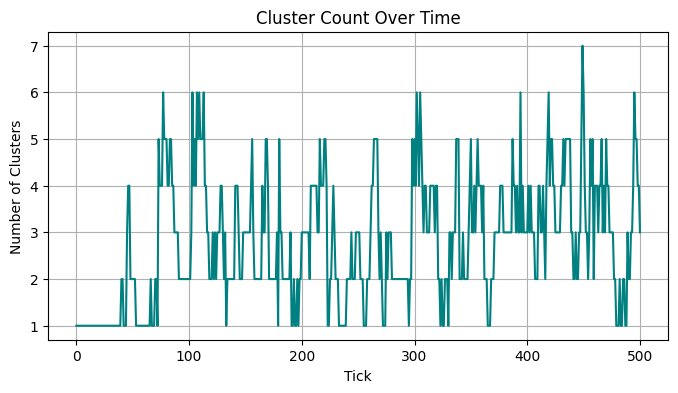

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(cluster_counts, color='teal')
plt.title("Cluster Count Over Time")
plt.xlabel("Tick")
plt.ylabel("Number of Clusters")
plt.grid(True)
plt.show()

/tmp/ipython-input-2095631116.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scat = ax.scatter([], [], s=50, cmap='viridis')


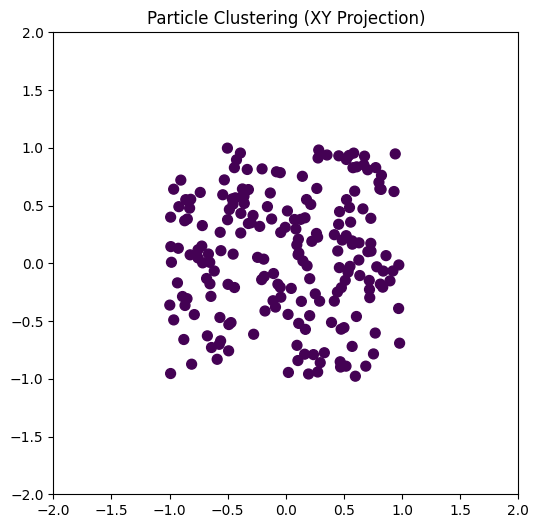

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

trajectory_array = np.array(trajectory)

fig, ax = plt.subplots(figsize=(6,6))
scat = ax.scatter([], [], s=50, cmap='viridis')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_title("Particle Clustering (XY Projection)")

def update(frame):
    pos = trajectory_array[frame]
    colors, _ = get_cluster_colors(pos[:, :2])
    colors = np.asarray(colors).flatten()

    # Map normalized values to RGBA using colormap
    cmap = plt.get_cmap('viridis')
    rgba_colors = cmap(colors)

    scat.set_offsets(pos[:, :2])
    scat.set_facecolor(rgba_colors)
    return scat,

ani = FuncAnimation(fig, update, frames=range(0, len(trajectory_array), 5), interval=100)
HTML(ani.to_html5_video())

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

trajectory_array = np.array(trajectory)

fig, ax = plt.subplots(figsize=(6,6))
scat = ax.scatter([], [], s=50)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_title("Particle Motion (XY Projection)")

def update(frame):
    pos = trajectory_array[frame]
    scat.set_offsets(pos[:, :2])
    return scat,

ani = FuncAnimation(fig, update, frames=len(trajectory_array), interval=100)
HTML(ani.to_html5_video())